In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition,
                  PNormDistance, History, AdaptivePopulationSize)
from pyabc.visualization import plot_kde_matrix, kde_1d
from pyabc.sampler import DaskDistributedSampler, SingleCoreSampler
from pyabc.transition import LocalTransition
import pyabc.visualization

import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import random
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulator import simulate

In [ ]:
#matplotlib.rcParams['figure.dpi']= 80

In [ ]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=17, threads_per_worker = 2)
client = Client(c,timeout=90)

In [2]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/raw/adult_data.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
study_data

{'1_5_Adults': 9446.1,
 '1_6_Adults': 6680.72,
 '1_8_Adults': 16291.1,
 '2_5_Adults': 23273.0,
 '2_6_Adults': 8159.24,
 '2_8_Adults': 13142.4,
 '3_5_Adults': 8104.48,
 '3_6_Adults': 23450.97,
 '3_8_Adults': 17947.59,
 '4_5_Adults': 5676.786667,
 '4_6_Adults': 11919.42667,
 '4_8_Adults': 17295.03333,
 '5_5_Adults': 6297.4,
 '5_6_Adults': 7885.44,
 '5_8_Adults': 21274.26,
 '6_5_Adults': 5667.66,
 '6_6_Adults': 19343.97,
 '6_8_Adults': 15127.45,
 '7_5_Adults': 11764.27333,
 '7_6_Adults': 13972.92667,
 '7_8_Adults': 13051.13333,
 '8_5_Adults': 8159.24,
 '8_6_Adults': 9126.666667,
 '8_8_Adults': 12631.30667,
 '9_5_Adults': 4709.36,
 '9_6_Adults': 9637.76,
 '9_8__Adults': 12375.76,
 '10_5_Adults': 5270.65,
 '10_6_Adults': 20493.93,
 '10_8_Adults': 13566.79}

In [3]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(-4, -1), #transformed to 0.0001 - .1
              AIAdultSlope=(1, 9),
              AILarvaLD50=(-4,-1),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(-4, -1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AIAdultSlope=(1, 9),
              AILarvaLD50=(-4,-1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [ ]:
# Set our distance function and sampler
distance = pyabc.PNormDistance(p=1)

sampler = DaskDistributedSampler(dask_client = client)
#sampler = SingleCoreSampler()

transition = LocalTransition()

In [ ]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(500, max_population_size = 500),
             transitions = transition,
             sampler=sampler)

In [ ]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_2_14.db"))
abc.new(db_path, study_data)

In [5]:
history = abc.run(max_nr_populations=30, minimum_epsilon=0)

NameError: name 'abc' is not defined

In [6]:
pop_data = history.get_all_populations()
pop_data

,t,population_end_time,samples,epsilon,particles
0,-1,2019-02-14 16:55:27.908223,0,0.000000,1
1,0,2019-02-14 18:48:59.842758,1107,305696.993340,500
2,1,2019-02-14 20:31:36.556703,1328,266782.443340,500
3,2,2019-02-14 22:18:28.052810,1403,238734.880143,500
4,3,2019-02-15 00:19:42.252762,1596,215145.520961,500
5,4,2019-02-15 02:57:23.321880,2249,202624.228900,500
6,5,2019-02-15 06:48:19.107800,3301,193379.253335,500
7,6,2019-02-15 11:58:05.512926,4540,186887.371931,500
8,7,2019-02-15 19:37:00.050399,6730,182516.980334,500
9,8,2019-02-16 04:25:56.031019,7947,178504.834597,500


In [7]:
#get acceptance rates for each generation
print("Acceptance rates")
for gen, samples, particles in zip(pop_data['t'],pop_data['samples'], pop_data['particles']):
    if(samples>0):
        print("Gen {}: {:.1f}%".format(gen+1,particles/samples*100))

Acceptance rates
Gen 1: 45.2%
Gen 2: 37.7%
Gen 3: 35.6%
Gen 4: 31.3%
Gen 5: 22.2%
Gen 6: 15.1%
Gen 7: 11.0%
Gen 8: 7.4%
Gen 9: 6.3%


In [10]:
t = history.max_t
df, w = history.get_distribution(m=0, t=t)

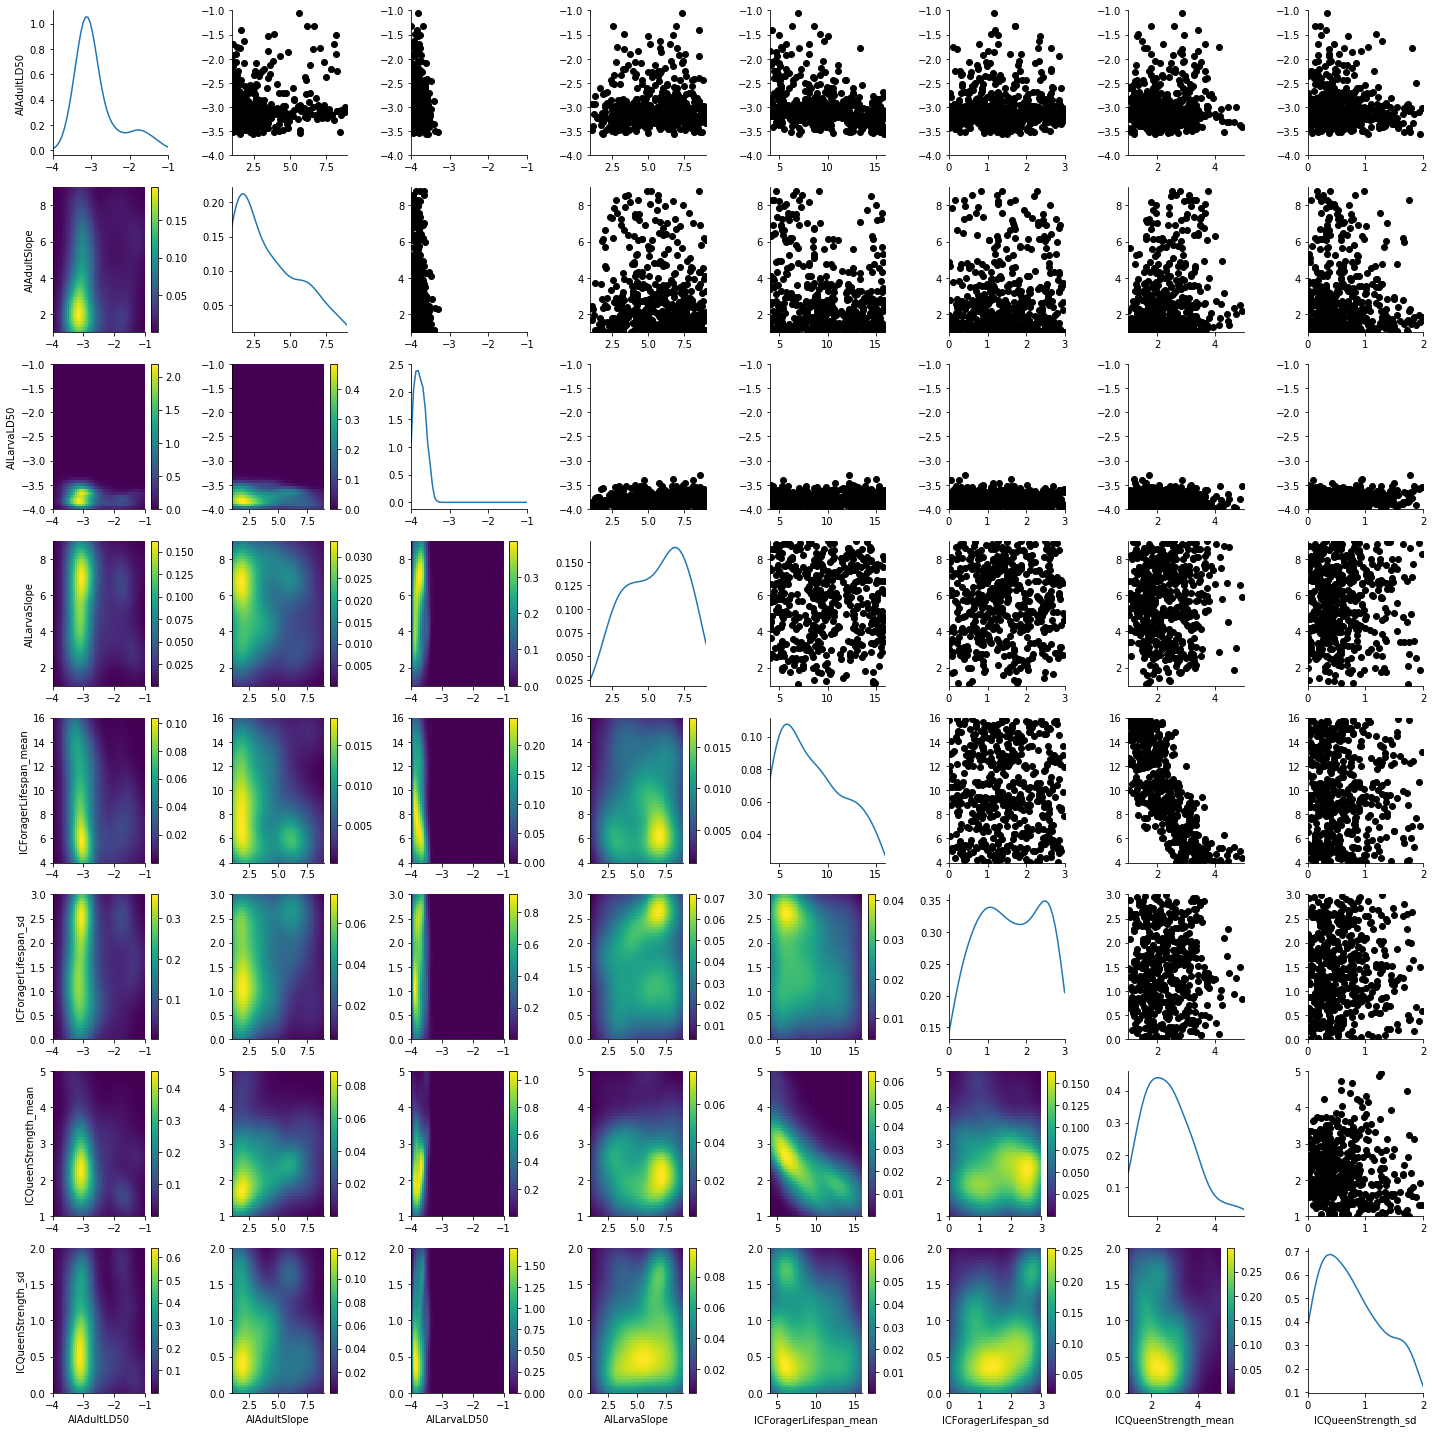

In [11]:
plot_kde_matrix(df, w, limits=limits);

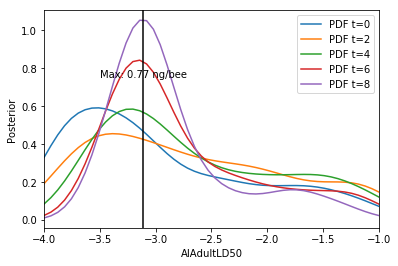

In [12]:
variable = 'AIAdultLD50'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1,2):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=-4, xmax=-1,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.legend()
ax.annotate('Max: {:.2f} ng/bee'.format(10**MAP.item()*1000), xy = (-3.5,0.75))
plt.show()

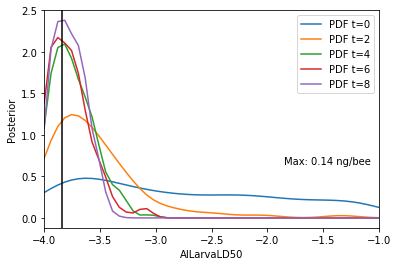

In [13]:
variable = 'AILarvaLD50'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1,2):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=-4, xmax=-1,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
ax.legend()
plt.axvline(x=MAP.item(),color='black')
ax.annotate('Max: {:.2f} ng/bee'.format(10**MAP.item()*1000), xy = (-1.85,0.65))
plt.show()

In [14]:
#get the maximum a posteriori estimation for AdultLD50
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
adult_ld50_map = (10**MAP.item()) * 1000 #un-log transformed and converted to ng/bee

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
adult_ld50_median = (10**x.item(np.min(np.where(cdf > .5))))*1000 #un-log transformed and converted to ng/bee
print('Adult LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(adult_ld50_map, adult_ld50_median))

# calculate 95% credible interval
adult_ld50_lower = (10**x.item(np.min(np.where(cdf > .025))))*1000
adult_ld50_upper = (10**x.item(np.min(np.where(cdf > .975))))*1000
print("95% CI: {} - {}".format(adult_ld50_lower, adult_ld50_upper))

Adult LD50 MAP: 0.77 ng/bee, median: 1.01 ng/bee
95% CI: 0.3051782235776414 - 40.56902253650061


In [15]:
#get the maximum a posteriori estimation for LarvaLD50
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
larva_ld50_map = (10**MAP.item()) * 1000 #un-log transformed and converted to ng/bee

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
larva_ld50_median = (10**x.item(np.min(np.where(cdf > .5))))*1000 #un-log transformed and converted to ng/bee
print('Larva LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(larva_ld50_map, larva_ld50_median))

# calculate 95% credible interval
larva_ld50_lower = (10**x.item(np.min(np.where(cdf > .025))))*1000
larva_ld50_upper = (10**x.item(np.min(np.where(cdf > .975))))*1000
print("95% CI: {} - {}".format(larva_ld50_lower, larva_ld50_upper))

Larva LD50 MAP: 0.14 ng/bee, median: 0.17 ng/bee
95% CI: 0.10437661953685616 - 0.33478411222353816


### Load a stored run

In [16]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_2_14.db"))
history = History(db_path)
history.id = 1

### More visuals

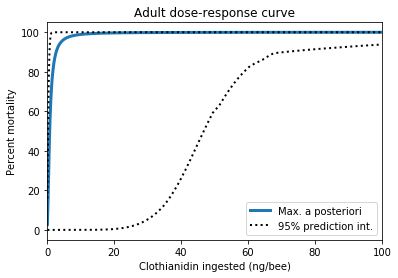

In [17]:
### Plot MAP and 95% Prediction interval
def draw_posterior(df, w, n=1):
    indices = df.index
    draws = random.choices(population=indices, weights = w, k=n)
    return df.loc[draws,:]

def get_prediction_interval(sample_in, percent=95, max_dose=100, adult=True):
    """
    Get PIs for dose-response curve. 
    Function that takes a set of samples of the posterior (as a input) and returns
    the lower and upper perdiction intervals as 1d arrays.
    """
    sample = sample_in.reset_index(drop=True)
    x = np.linspace(0,max_dose, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = np.empty([len(sample.index),x.size])
    if adult:
        for index, row in sample.iterrows():
            ld50 = (10**row[0]) * 1000
            slope = row[1]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    else:
        for index, row in sample.iterrows():
            ld50 = (10**row[2]) * 1000
            slope = row[3]
            y[index,:] = 100/(1+(ld50/x)**slope) #four parameters Hill equation
    lower = np.percentile(y,q=(100-percent)/2, axis=0)
    upper = np.percentile(y, q=100-((100-percent)/2), axis=0)
    return lower, upper


def plot_dr_map(df, adult=True, xlim=100, ci=True, percent = 95, sample_num=500, title="Dose-response curve"):
    """
    Plot the dose-response curve for a posterior based on maximum a posteriori values.
    Can also include prediction intervals, which are based on weighted random sampling of the particles. 
    """
    if adult:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AIAdultLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        ld50_MAP =  (10**ld50_MAP) * 1000 #unlog transform and convert to ng/bee
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AIAdultSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    else:
        #get ld50 MAP
        x_ld50, pdf_ld50 = kde_1d(df,w,'AILarvaLD50', numx = 200)
        ld50_MAP = x_ld50[np.where(np.max(pdf_ld50)==pdf_ld50)]
        ld50_MAP =  (10**ld50_MAP) * 1000 #unlog transform and convert to ng/bee
        #get slope MAP
        x_slope, pdf_slope = kde_1d(df,w,'AILarvaSlope', numx = 200)
        slope_MAP = x_slope[np.where(np.max(pdf_slope)==pdf_slope)]
    sample = draw_posterior(df, w, sample_num)
    lower, upper = get_prediction_interval(sample, max_dose=xlim, adult=adult)
    fix, ax = plt.subplots()
    x = np.linspace(0,xlim, 1000)
    x = np.delete(x, 0) #remove 0 dose so we don't divide by zero
    y = 100/(1+(ld50_MAP/x)**slope_MAP) #four parameters Hill equation, equal to what VarroaPop uses
    ax.plot(x, y, linewidth=3, label="Max. a posteriori")
    ax.plot(x,lower, 'k', linestyle=":", linewidth=2, label="95% prediction int.")
    ax.plot(x,upper, 'k', linestyle=":", linewidth=2)
    ax.set(xlabel='Clothianidin ingested (ng/bee)', ylabel='Percent mortality', title=title, xlim=(0,xlim))
    ax.legend()
    plt.show()

#for adults
random.seed(1251)
plot_dr_map(df, percent=95, xlim=100, title = "Adult dose-response curve")

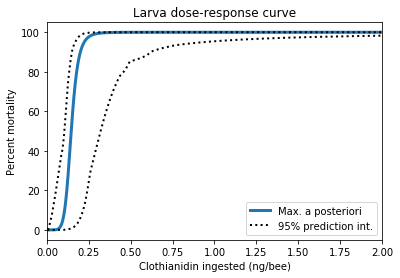

In [18]:
# MAP and PI plot for larvae
random.seed(1251)
plot_dr_map(df, percent=95, xlim = 2, adult=False, title = "Larva dose-response curve")

### Test data simulator

In [19]:
pars = dict(ICQueenStrength_mean=3,
            ICQueenStrength_sd=1,
            ICForagerLifespan_mean=8,
            ICForagerLifespan_sd=2,
            AIAdultLD50=-2,
            AIAdultSlope=3,
            AILarvaLD50=-2,
            AILarvaSlope=3)

In [20]:
#simulate(pars, save=False, logs=False)